# Twitter Semantic Analysis 

Business Objective:	
- Need to get sentiment analysis of tweets gauge its impact and type

Architecture level analysis:


1.Data transformation/Text processing using R/Python

2.Need to get sentiments Analysis and Emotion mining with some charts like histogram, Density plot, Barplot, pie-plot etc.

3.Deployment through R Shiny or Flask/ Streamlit


# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re 
import nltk
from nltk import word_tokenize, pos_tag, pos_tag_sents
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stopwords= nltk.corpus.stopwords.words('english')
from wordcloud import WordCloud
from nltk.stem import PorterStemmer,WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report


import random
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Embedding
from sklearn.model_selection import train_test_split

# Loading Dataset

In [2]:
df=pd.read_csv("tweet.csv")

In [3]:
df.head()

,tweets,class
0,Be aware dirty step to get money #staylight ...,figurative
1,#sarcasm for #people who don't understand #diy...,figurative
2,@IminworkJeremy @medsingle #DailyMail readers ...,figurative
3,@wilw Why do I get the feeling you like games?...,figurative
4,-@TeacherArthurG @rweingarten You probably jus...,figurative


In [4]:
df["tweets"][0]

'Be aware  dirty step to get money  #staylight #staywhite  #sarcastic #moralneeded @… https://t.co/Oj6BdyX3WG'

# EDA 

In [5]:
df.shape

(81408, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81408 entries, 0 to 81407
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweets  81408 non-null  object
 1   class   81408 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [7]:
df["class"].value_counts()

figurative    21238
irony         20894
sarcasm       20681
regular       18595
Name: class, dtype: int64

### Checking for null values

In [8]:
df.isna().sum()

tweets    0
class     0
dtype: int64

### Checking for Duplicate values

In [9]:
df.duplicated().sum()

49

In [10]:
# dropping the duplicates in text
df=df.drop_duplicates(keep="first")

In [11]:
df.duplicated().sum()

0

In [12]:
df.shape

(81359, 2)

In [13]:
df["class"].nunique()

4

### Distribution of Target class

In [14]:
df["class"].value_counts()

figurative    21235
irony         20877
sarcasm       20678
regular       18569
Name: class, dtype: int64

### count plot for class distribution

<AxesSubplot:xlabel='class', ylabel='count'>

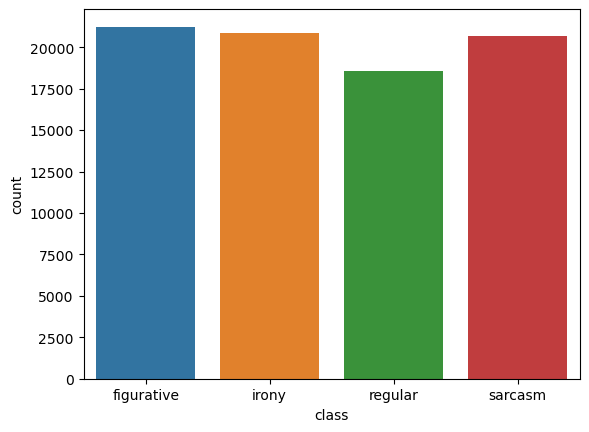

In [15]:
sns.countplot(x="class",data=df)

### Pie chart representing class distribution

<AxesSubplot:ylabel='class'>

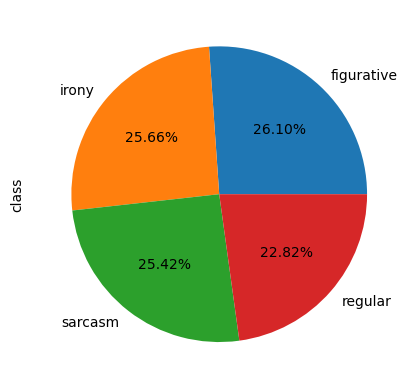

In [16]:
df["class"].value_counts().plot(kind = "pie", autopct='%.2f%%')

- ### Data is balanced

### Creating new columns

In [17]:
## num of characters
df["num_characters"]=df["tweets"].apply(len)

In [18]:
df.head()

,tweets,class,num_characters
0,Be aware dirty step to get money #staylight ...,figurative,108
1,#sarcasm for #people who don't understand #diy...,figurative,80
2,@IminworkJeremy @medsingle #DailyMail readers ...,figurative,132
3,@wilw Why do I get the feeling you like games?...,figurative,55
4,-@TeacherArthurG @rweingarten You probably jus...,figurative,75


In [19]:
# figurative class distribution
df[df["class"]=="figurative"]["num_characters"].describe()

count    21235.000000
mean        99.532894
std         31.273433
min          6.000000
25%         74.000000
50%        103.000000
75%        129.000000
max        161.000000
Name: num_characters, dtype: float64

In [20]:
# irony class distribution
df[df["class"]=="irony"]['num_characters'].describe()

count    20877.000000
mean       103.887005
std         30.502410
min          6.000000
25%         79.000000
50%        109.000000
75%        133.000000
max        152.000000
Name: num_characters, dtype: float64

In [21]:
# sarcasm class distribution
df[df["class"]=="sarcasm"]['num_characters'].describe()

count    20678.000000
mean        95.561321
std         31.384390
min          8.000000
25%         70.000000
50%         96.000000
75%        125.000000
max        161.000000
Name: num_characters, dtype: float64

In [22]:
# regular class distribution
df[df["class"]=="regular"]['num_characters'].describe()

count    18569.000000
mean       111.854596
std         26.777406
min         19.000000
25%         94.000000
50%        120.000000
75%        135.000000
max        156.000000
Name: num_characters, dtype: float64

<AxesSubplot:xlabel='num_characters', ylabel='Count'>

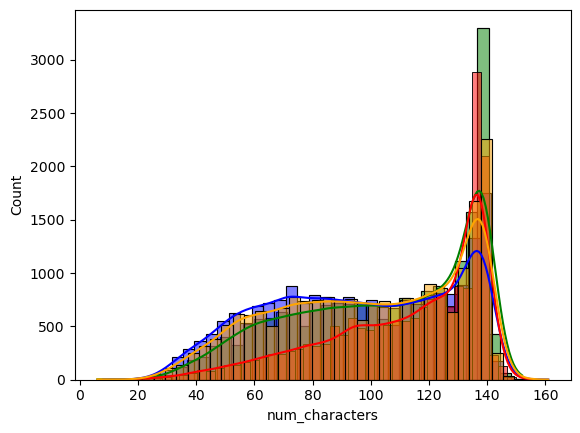

In [23]:
# num of characters distribution in each class 

ax=sns.histplot(df[df["class"]=="irony"]["num_characters"],kde="True",color="green")
sns.histplot(df[df["class"]=="sarcasm"]["num_characters"],kde="True",color="blue")
sns.histplot(df[df["class"]=="regular"]["num_characters"],kde="True",color="red")
sns.histplot(df[df["class"]=="figurative"]["num_characters"],kde="True",color="orange")

In [24]:
# df["sarcastic"]=df['tweets'].str.contains('#sarcastic',"#sarcasm")

In [25]:
# sns.countplot(df[df["class"]=="sarcasm"]["sarcastic"])

# Data Preprocessing

###  Basic Text Cleaning

In [26]:
# Basic Text Cleaning

def clean_text(text):
    
    text=text.lower() # Lower Case
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE) # Remove URLs
    text = re.sub(r"@\w+|\#", "", text)  # Remove mentions and hashtags
    text = re.sub(r"[^a-zA-Z]", " ", text) # Remove special characters and numbers, keep only alphabetic characters
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return "".join(text)

In [27]:
df["cleaned_tweets"]=df["tweets"].apply(clean_text)

In [28]:
df.head()

,tweets,class,num_characters,cleaned_tweets
0,Be aware dirty step to get money #staylight ...,figurative,108,be aware dirty step to get money staylight sta...
1,#sarcasm for #people who don't understand #diy...,figurative,80,sarcasm for people who don t understand diy ar...
2,@IminworkJeremy @medsingle #DailyMail readers ...,figurative,132,dailymail readers being sensible as always sho...
3,@wilw Why do I get the feeling you like games?...,figurative,55,why do i get the feeling you like games sarcasm
4,-@TeacherArthurG @rweingarten You probably jus...,figurative,75,you probably just missed the text sarcastic


In [29]:
df["tweets"][1]

"#sarcasm for #people who don't understand #diy #artattack http://t.co/rtyYmuDVUS"

In [30]:
df["cleaned_tweets"][1]

'sarcasm for people who don t understand diy artattack'

### Tokenization

In [31]:
# Tokenization
def tokenize_text(text):
    return word_tokenize(text)

df['tokens'] = df['cleaned_tweets'].apply(tokenize_text)

### Stopword Removal

In [32]:
# Stopword Removal
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stopwords]

df['tokens'] = df['tokens'].apply(remove_stopwords)

### Stemming

In [33]:
# Stemming
def stem_text(tokens):
    ps=PorterStemmer()
    return " ".join([ps.stem(token) for token in tokens])
df["stem_tokens"]=df['tokens'].apply(stem_text)

### Lemmatization

In [34]:
# Lemmatization
def lemmatize_text(tokens):
    lm=WordNetLemmatizer()
    return " ".join([lm.lemmatize(token,pos='v') for token in tokens])

df['lemmatized_tokens'] = df['tokens'].apply(lemmatize_text)

In [35]:
df.head()

,tweets,class,num_characters,cleaned_tweets,tokens,stem_tokens,lemmatized_tokens
0,Be aware dirty step to get money #staylight ...,figurative,108,be aware dirty step to get money staylight sta...,"[aware, dirty, step, get, money, staylight, st...",awar dirti step get money staylight staywhit s...,aware dirty step get money staylight staywhite...
1,#sarcasm for #people who don't understand #diy...,figurative,80,sarcasm for people who don t understand diy ar...,"[sarcasm, people, understand, diy, artattack]",sarcasm peopl understand diy artattack,sarcasm people understand diy artattack
2,@IminworkJeremy @medsingle #DailyMail readers ...,figurative,132,dailymail readers being sensible as always sho...,"[dailymail, readers, sensible, always, shocker...",dailymail reader sensibl alway shocker sarcast...,dailymail readers sensible always shocker sarc...
3,@wilw Why do I get the feeling you like games?...,figurative,55,why do i get the feeling you like games sarcasm,"[get, feeling, like, games, sarcasm]",get feel like game sarcasm,get feel like game sarcasm
4,-@TeacherArthurG @rweingarten You probably jus...,figurative,75,you probably just missed the text sarcastic,"[probably, missed, text, sarcastic]",probabl miss text sarcast,probably miss text sarcastic


In [36]:
 nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Nikhit
[nltk_data]     Chokhandre\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## POS tagging 

In [37]:
df['POS'] = df['tokens'].apply(nltk.pos_tag)

In [38]:
df.head()

,tweets,class,num_characters,cleaned_tweets,tokens,stem_tokens,lemmatized_tokens,POS
0,Be aware dirty step to get money #staylight ...,figurative,108,be aware dirty step to get money staylight sta...,"[aware, dirty, step, get, money, staylight, st...",awar dirti step get money staylight staywhit s...,aware dirty step get money staylight staywhite...,"[(aware, JJ), (dirty, JJ), (step, NN), (get, V..."
1,#sarcasm for #people who don't understand #diy...,figurative,80,sarcasm for people who don t understand diy ar...,"[sarcasm, people, understand, diy, artattack]",sarcasm peopl understand diy artattack,sarcasm people understand diy artattack,"[(sarcasm, JJ), (people, NNS), (understand, VB..."
2,@IminworkJeremy @medsingle #DailyMail readers ...,figurative,132,dailymail readers being sensible as always sho...,"[dailymail, readers, sensible, always, shocker...",dailymail reader sensibl alway shocker sarcast...,dailymail readers sensible always shocker sarc...,"[(dailymail, NN), (readers, NNS), (sensible, J..."
3,@wilw Why do I get the feeling you like games?...,figurative,55,why do i get the feeling you like games sarcasm,"[get, feeling, like, games, sarcasm]",get feel like game sarcasm,get feel like game sarcasm,"[(get, VB), (feeling, NN), (like, IN), (games,..."
4,-@TeacherArthurG @rweingarten You probably jus...,figurative,75,you probably just missed the text sarcastic,"[probably, missed, text, sarcastic]",probabl miss text sarcast,probably miss text sarcastic,"[(probably, RB), (missed, VBD), (text, JJ), (s..."


In [39]:
df['nouns'] = df['POS'].apply(lambda x: [word for word, tag in x if tag in ['NN', 'NNS', 'NNP', 'NNPS']])
df[['tweets', 'nouns']].head()

,tweets,nouns
0,Be aware dirty step to get money #staylight ...,"[step, money]"
1,#sarcasm for #people who don't understand #diy...,"[people, artattack]"
2,@IminworkJeremy @medsingle #DailyMail readers ...,"[dailymail, readers, dailyfail, inhuntspocket,..."
3,@wilw Why do I get the feeling you like games?...,"[feeling, games]"
4,-@TeacherArthurG @rweingarten You probably jus...,[]


In [40]:
df['verbs'] = df['POS'].apply(lambda x: [word for word, tag in x if tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']])
df[['tweets', 'verbs']].head()

,tweets,verbs
0,Be aware dirty step to get money #staylight ...,"[get, staylight, moralneeded]"
1,#sarcasm for #people who don't understand #diy...,[understand]
2,@IminworkJeremy @medsingle #DailyMail readers ...,[shocker]
3,@wilw Why do I get the feeling you like games?...,"[get, sarcasm]"
4,-@TeacherArthurG @rweingarten You probably jus...,[missed]


## Topic Modeling 

In [41]:
from sklearn.decomposition import LatentDirichletAllocation

vc=TfidfVectorizer()
p=vc.fit_transform(df["lemmatized_tokens"])
lda=LatentDirichletAllocation(n_components=10)
lda.fit(p)
print(lda.components_)

[[0.10000926 4.24740287 0.81017523 ... 0.1        0.1        0.1       ]
 [0.10000082 0.10000859 0.1        ... 0.1        0.1000184  0.1       ]
 [0.10000021 0.10000218 0.1        ... 0.1        0.97883004 0.1       ]
 ...
 [0.1        0.1        0.1        ... 0.1        0.1        0.1       ]
 [0.40465563 0.1        0.1        ... 0.1        0.1        0.1       ]
 [5.78707094 0.10000289 0.1        ... 0.1        0.10000305 1.50542782]]


In [42]:
for idx,topic in enumerate(lda.components_):
    print(f"Topic {idx+1}:")
    top_words_idx=topic.argsort()[-5:][::-1]
    top_words=[vc.get_feature_names_out()[i]for i in top_words_idx]
    print(", ".join(top_words))
    print()

Topic 1:
sarcasm, irony, get, ironic, great

Topic 2:
irony, sarcasm, politics, gopdebate, trump

Topic 3:
irony, sarcasm, humor, gt, ironic

Topic 4:
sarcasm, irony, ironic, get, day

Topic 5:
irony, sarcasm, ironic, people, love

Topic 6:
irony, sarcasm, peace, ironic, news

Topic 7:
sarcasm, irony, ironic, news, education

Topic 8:
sarcasm, irony, ironic, late, go

Topic 9:
sarcasm, funny, irony, internet, humor

Topic 10:
sarcasm, irony, ironic, late, get



## TextBlob
- As TextBlob is a Lexicon-based sentiment analyzer It has some predefined rules or we can say word and weight dictionary, where   it has some scores that help to calculate a sentence's polarity.

- TextBlob returns polarity of a sentence. 
- Polarity lies between [-1,1] -1 defines a negative sentiment and 1 defines a positive sentiment.

## Sentiment analysis using Textblob

In [43]:
from textblob import TextBlob

In [44]:
 def getPolarity(text):
        return TextBlob(text).sentiment.polarity

In [45]:
df['polarity'] = df['lemmatized_tokens'].apply(getPolarity)

In [46]:
df.head()

,tweets,class,num_characters,cleaned_tweets,tokens,stem_tokens,lemmatized_tokens,POS,nouns,verbs,polarity
0,Be aware dirty step to get money #staylight ...,figurative,108,be aware dirty step to get money staylight sta...,"[aware, dirty, step, get, money, staylight, st...",awar dirti step get money staylight staywhit s...,aware dirty step get money staylight staywhite...,"[(aware, JJ), (dirty, JJ), (step, NN), (get, V...","[step, money]","[get, staylight, moralneeded]",-0.083333
1,#sarcasm for #people who don't understand #diy...,figurative,80,sarcasm for people who don t understand diy ar...,"[sarcasm, people, understand, diy, artattack]",sarcasm peopl understand diy artattack,sarcasm people understand diy artattack,"[(sarcasm, JJ), (people, NNS), (understand, VB...","[people, artattack]",[understand],0.000000
2,@IminworkJeremy @medsingle #DailyMail readers ...,figurative,132,dailymail readers being sensible as always sho...,"[dailymail, readers, sensible, always, shocker...",dailymail reader sensibl alway shocker sarcast...,dailymail readers sensible always shocker sarc...,"[(dailymail, NN), (readers, NNS), (sensible, J...","[dailymail, readers, dailyfail, inhuntspocket,...",[shocker],0.100000
3,@wilw Why do I get the feeling you like games?...,figurative,55,why do i get the feeling you like games sarcasm,"[get, feeling, like, games, sarcasm]",get feel like game sarcasm,get feel like game sarcasm,"[(get, VB), (feeling, NN), (like, IN), (games,...","[feeling, games]","[get, sarcasm]",-0.400000
4,-@TeacherArthurG @rweingarten You probably jus...,figurative,75,you probably just missed the text sarcastic,"[probably, missed, text, sarcastic]",probabl miss text sarcast,probably miss text sarcastic,"[(probably, RB), (missed, VBD), (text, JJ), (s...",[],[missed],0.100000


In [47]:
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score >0:
        return 'Positive'
    else:
        return 'Neutral'
        

In [48]:
df['sentiment'] = df['polarity'].apply(getAnalysis)

In [49]:
df['sentiment'].value_counts()

Positive    38803
Neutral     27760
Negative    14796
Name: sentiment, dtype: int64

### converting the score into reaction.
- positive reaction (1)
- negative reaction (-1)
- neutral reaction (0)

In [50]:
df.sentiment = df.sentiment.map({'Negative':-1,'Positive':1,'Neutral':0})

C:\Users\Nikhit Chokhandre\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sentiment', ylabel='Density'>

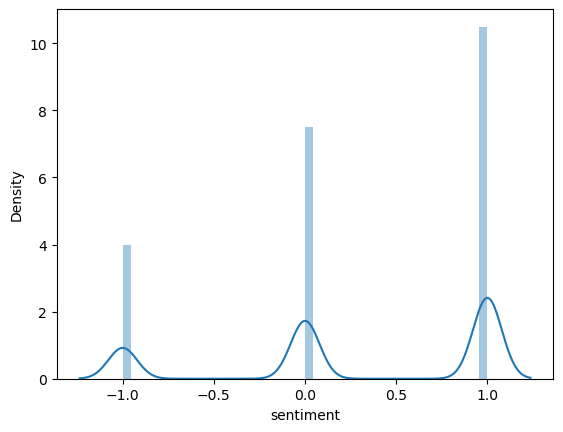

In [51]:
sns.distplot(df.sentiment)

In [52]:
df.head()

,tweets,class,num_characters,cleaned_tweets,tokens,stem_tokens,lemmatized_tokens,POS,nouns,verbs,polarity,sentiment
0,Be aware dirty step to get money #staylight ...,figurative,108,be aware dirty step to get money staylight sta...,"[aware, dirty, step, get, money, staylight, st...",awar dirti step get money staylight staywhit s...,aware dirty step get money staylight staywhite...,"[(aware, JJ), (dirty, JJ), (step, NN), (get, V...","[step, money]","[get, staylight, moralneeded]",-0.083333,-1
1,#sarcasm for #people who don't understand #diy...,figurative,80,sarcasm for people who don t understand diy ar...,"[sarcasm, people, understand, diy, artattack]",sarcasm peopl understand diy artattack,sarcasm people understand diy artattack,"[(sarcasm, JJ), (people, NNS), (understand, VB...","[people, artattack]",[understand],0.000000,0
2,@IminworkJeremy @medsingle #DailyMail readers ...,figurative,132,dailymail readers being sensible as always sho...,"[dailymail, readers, sensible, always, shocker...",dailymail reader sensibl alway shocker sarcast...,dailymail readers sensible always shocker sarc...,"[(dailymail, NN), (readers, NNS), (sensible, J...","[dailymail, readers, dailyfail, inhuntspocket,...",[shocker],0.100000,1
3,@wilw Why do I get the feeling you like games?...,figurative,55,why do i get the feeling you like games sarcasm,"[get, feeling, like, games, sarcasm]",get feel like game sarcasm,get feel like game sarcasm,"[(get, VB), (feeling, NN), (like, IN), (games,...","[feeling, games]","[get, sarcasm]",-0.400000,-1
4,-@TeacherArthurG @rweingarten You probably jus...,figurative,75,you probably just missed the text sarcastic,"[probably, missed, text, sarcastic]",probabl miss text sarcast,probably miss text sarcastic,"[(probably, RB), (missed, VBD), (text, JJ), (s...",[],[missed],0.100000,1


C:\Users\Nikhit Chokhandre\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

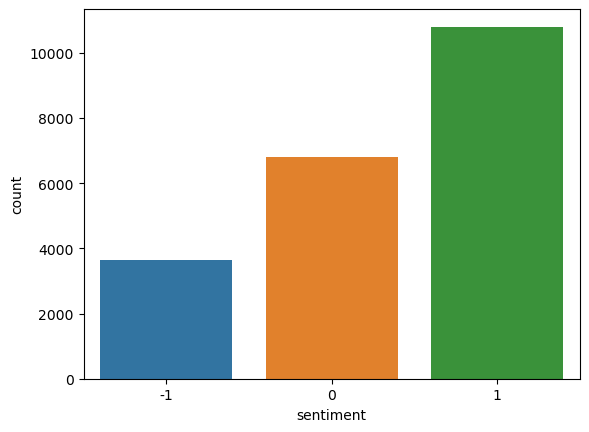

In [53]:
sns.countplot(df[df['class']=='figurative']["sentiment"])

C:\Users\Nikhit Chokhandre\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

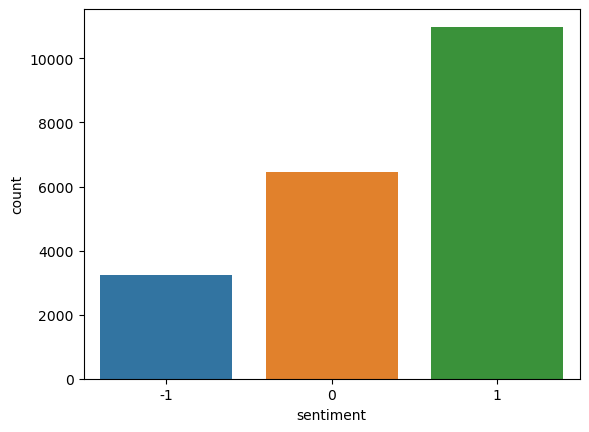

In [54]:
sns.countplot(df[df['class']=='sarcasm']["sentiment"])

C:\Users\Nikhit Chokhandre\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

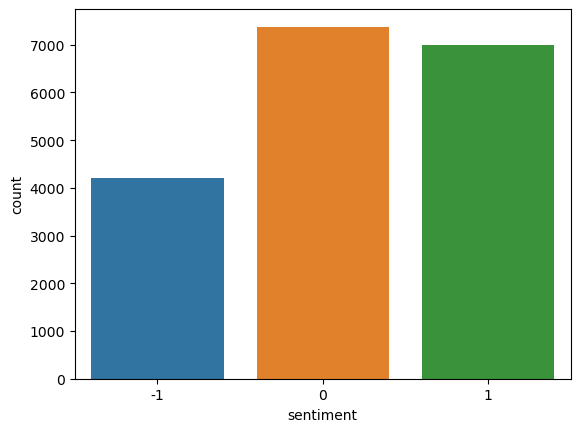

In [55]:
sns.countplot(df[df['class']=='regular']["sentiment"])

C:\Users\Nikhit Chokhandre\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

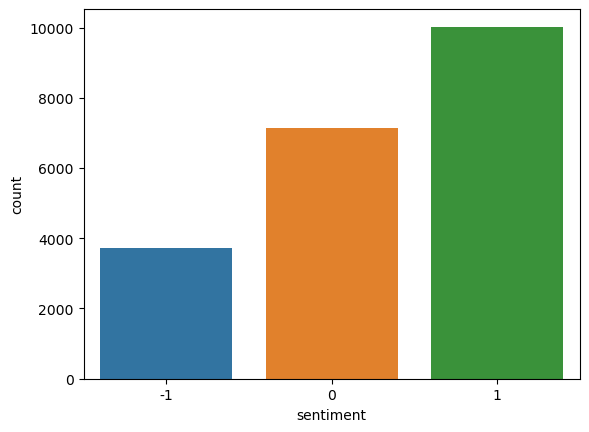

In [56]:
sns.countplot(df[df['class']=='irony']["sentiment"])

In [57]:
df["tweets"][155]

'So I\'m planning music for tonight\'s mass and the reading is about Pharaoh\'s army. I think I\'ll lead with "Come To The Water". #clever #irony'

In [58]:
df["cleaned_tweets"][155]

'so i m planning music for tonight s mass and the reading is about pharaoh s army i think i ll lead with come to the water clever irony'

In [59]:
df["sentiment"][155]

1

In [60]:
df["tokens"][155]

['planning',
 'music',
 'tonight',
 'mass',
 'reading',
 'pharaoh',
 'army',
 'think',
 'lead',
 'come',
 'water',
 'clever',
 'irony']

In [61]:
df["lemmatized_tokens"][155]

'plan music tonight mass read pharaoh army think lead come water clever irony'

In [62]:
df["stem_tokens"][155]

'plan music tonight mass read pharaoh armi think lead come water clever ironi'

In [63]:
df.head()

,tweets,class,num_characters,cleaned_tweets,tokens,stem_tokens,lemmatized_tokens,POS,nouns,verbs,polarity,sentiment
0,Be aware dirty step to get money #staylight ...,figurative,108,be aware dirty step to get money staylight sta...,"[aware, dirty, step, get, money, staylight, st...",awar dirti step get money staylight staywhit s...,aware dirty step get money staylight staywhite...,"[(aware, JJ), (dirty, JJ), (step, NN), (get, V...","[step, money]","[get, staylight, moralneeded]",-0.083333,-1
1,#sarcasm for #people who don't understand #diy...,figurative,80,sarcasm for people who don t understand diy ar...,"[sarcasm, people, understand, diy, artattack]",sarcasm peopl understand diy artattack,sarcasm people understand diy artattack,"[(sarcasm, JJ), (people, NNS), (understand, VB...","[people, artattack]",[understand],0.000000,0
2,@IminworkJeremy @medsingle #DailyMail readers ...,figurative,132,dailymail readers being sensible as always sho...,"[dailymail, readers, sensible, always, shocker...",dailymail reader sensibl alway shocker sarcast...,dailymail readers sensible always shocker sarc...,"[(dailymail, NN), (readers, NNS), (sensible, J...","[dailymail, readers, dailyfail, inhuntspocket,...",[shocker],0.100000,1
3,@wilw Why do I get the feeling you like games?...,figurative,55,why do i get the feeling you like games sarcasm,"[get, feeling, like, games, sarcasm]",get feel like game sarcasm,get feel like game sarcasm,"[(get, VB), (feeling, NN), (like, IN), (games,...","[feeling, games]","[get, sarcasm]",-0.400000,-1
4,-@TeacherArthurG @rweingarten You probably jus...,figurative,75,you probably just missed the text sarcastic,"[probably, missed, text, sarcastic]",probabl miss text sarcast,probably miss text sarcastic,"[(probably, RB), (missed, VBD), (text, JJ), (s...",[],[missed],0.100000,1


# Visualization

### Word cloud for regular class

Text(0.5, 1.0, 'WordCloud - regular class')

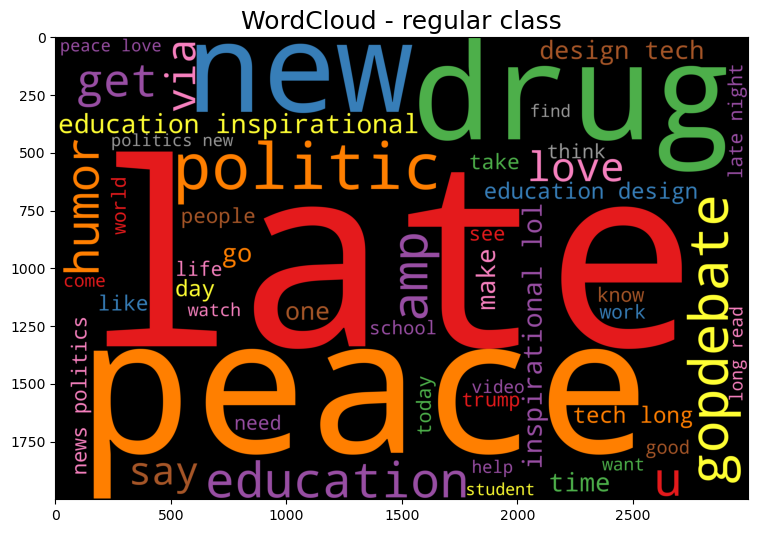

In [64]:
plt.figure(figsize=(12,6))
text =' '.join([text for text in df['lemmatized_tokens'][df['class'] == "regular"]])
wc = WordCloud(width = 3000, height = 2000, background_color = 'black', max_words = 50,
                   colormap = 'Set1',stopwords=stopwords).generate(text)
plt.imshow(wc)
plt.title("WordCloud - regular class", fontsize = 18)

### Word cloud for irony class

Text(0.5, 1.0, 'WordCloud - irony class')

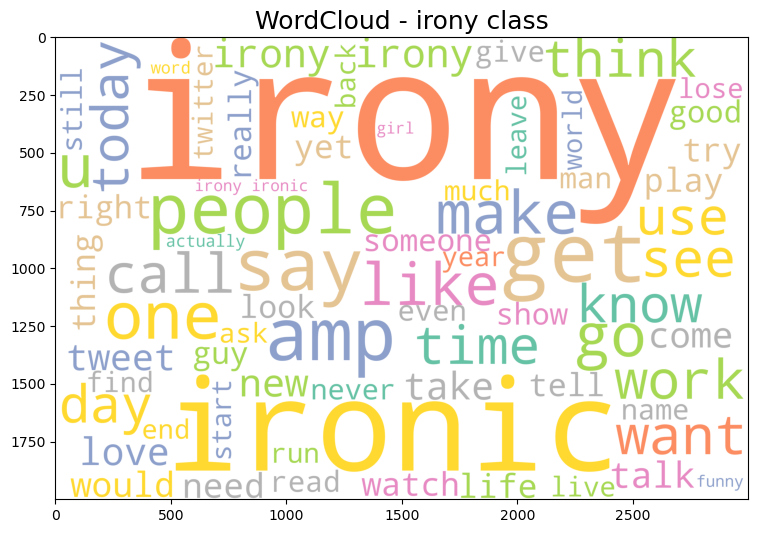

In [65]:
plt.figure(figsize=(12,6))
text =' '.join([text for text in df['lemmatized_tokens'][df['class'] == "irony"]])
wc = WordCloud(width = 3000, height = 2000, background_color = 'white', max_words = 70,
                   colormap = 'Set2',stopwords=stopwords).generate(text)
plt.imshow(wc)
plt.title("WordCloud - irony class", fontsize = 18)

### Word cloud for sarcasm class

Text(0.5, 1.0, 'WordCloud - sarcasm class')

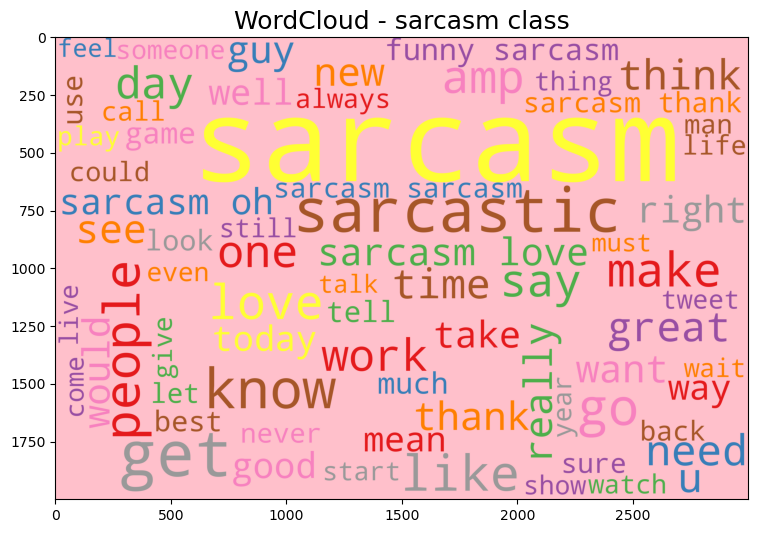

In [66]:
plt.figure(figsize=(12,6))
text =' '.join([text for text in df['lemmatized_tokens'][df['class'] == "sarcasm"]])
wc = WordCloud(width = 3000, height = 2000, background_color = 'pink', max_words = 70,
                   colormap = 'Set1',stopwords=stopwords).generate(text)
plt.imshow(wc)
plt.title("WordCloud - sarcasm class", fontsize = 18)

### Word cloud for figurative class

Text(0.5, 1.0, 'WordCloud - figurative class')

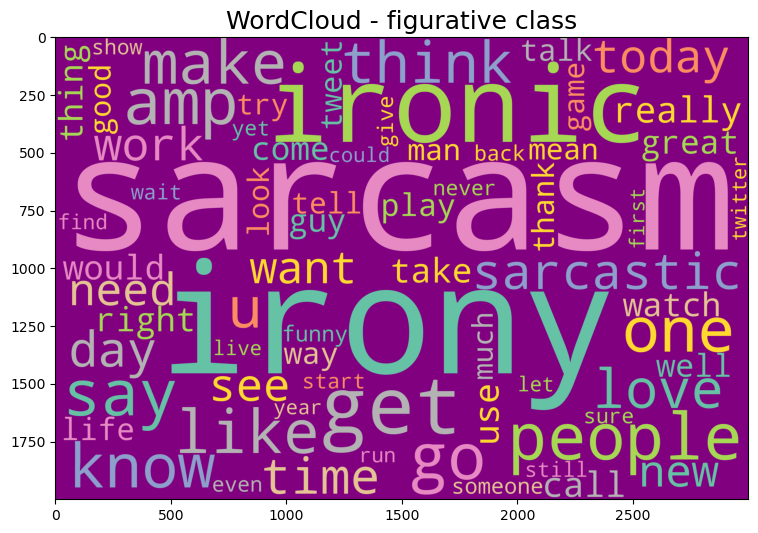

In [67]:
plt.figure(figsize=(12,6))
text =' '.join([text for text in df['lemmatized_tokens'][df['class'] == "figurative"]])
wc = WordCloud(width = 3000, height = 2000, background_color = 'purple', max_words = 70,
                   colormap = 'Set2',stopwords=stopwords).generate(text)
plt.imshow(wc)
plt.title("WordCloud - figurative class", fontsize = 18)

### Top 30 Most common words in Figurative class

In [68]:
figurative_corpus=[]
for msg in df[df['class'] == "figurative"]["lemmatized_tokens"].tolist():
    for word in msg.split():
        figurative_corpus.append(word)

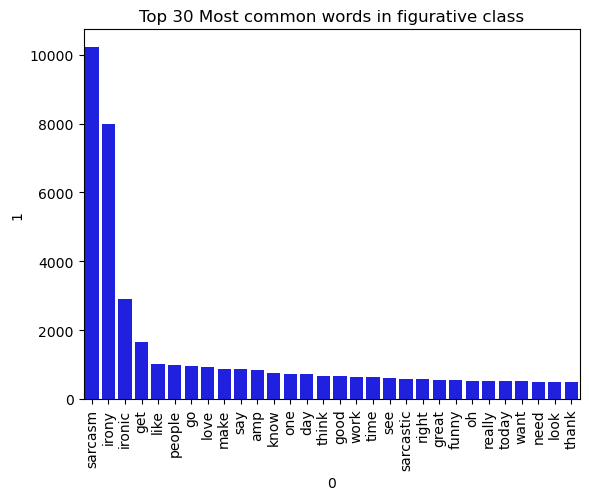

In [69]:
from collections import Counter
sns.barplot(x=pd.DataFrame(Counter(figurative_corpus).most_common(30))[0],y=pd.DataFrame(Counter(figurative_corpus).most_common(30))[1],color="blue")
plt.title("Top 30 Most common words in figurative class")
plt.xticks(rotation="vertical")
plt.show()

### Top 30 Most common words in sarcasm class

In [70]:
sarcasm_corpus=[]
for msg in df[df['class'] == "sarcasm"]["lemmatized_tokens"].tolist():
    for word in msg.split():
        sarcasm_corpus.append(word)

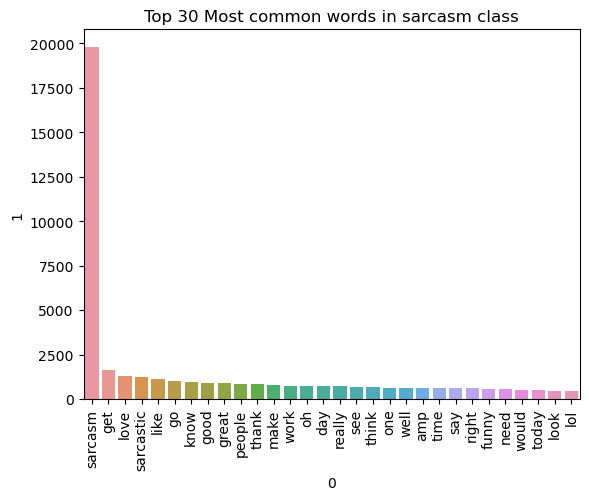

In [71]:
from collections import Counter
sns.barplot(x=pd.DataFrame(Counter(sarcasm_corpus).most_common(30))[0],y=pd.DataFrame(Counter(sarcasm_corpus).most_common(30))[1])
plt.title("Top 30 Most common words in sarcasm class")
plt.xticks(rotation="vertical")
plt.show()

### Top 30 Most common words in irony class

In [72]:
irony_corpus=[]
for msg in df[df['class'] == "irony"]["lemmatized_tokens"].tolist():
    for word in msg.split():
        irony_corpus.append(word)

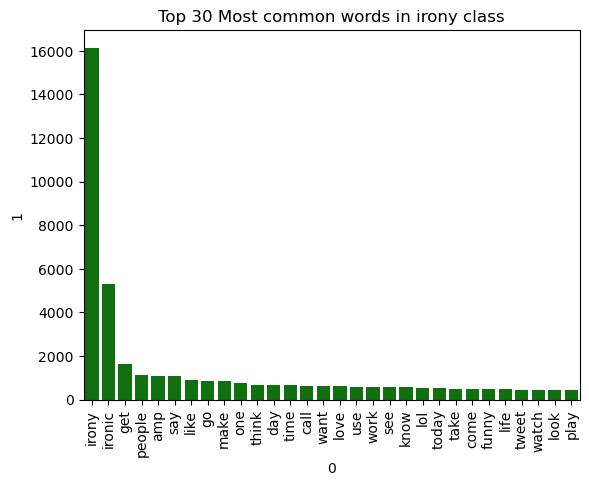

In [73]:
from collections import Counter
sns.barplot(x=pd.DataFrame(Counter(irony_corpus).most_common(30))[0],y=pd.DataFrame(Counter(irony_corpus).most_common(30))[1],color="green")
plt.title("Top 30 Most common words in irony class")
plt.xticks(rotation="vertical")
plt.show()

### Top 30 Most common words in regular class

In [74]:
regular_corpus=[]
for msg in df[df['class'] == "regular"]["lemmatized_tokens"].tolist():
    for word in msg.split():
        regular_corpus.append(word)

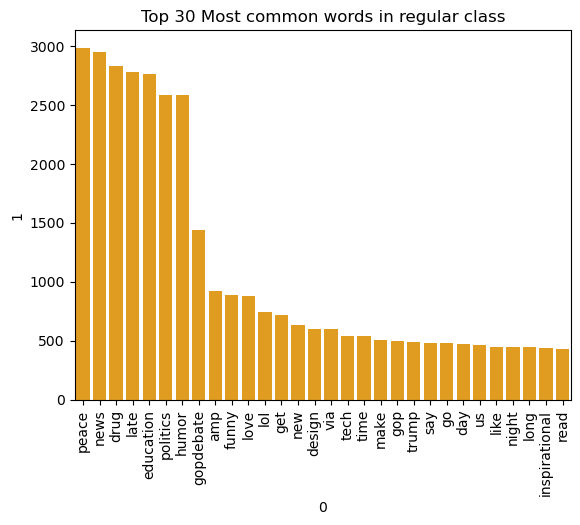

In [75]:
from collections import Counter
sns.barplot(x=pd.DataFrame(Counter(regular_corpus).most_common(30))[0],y=pd.DataFrame(Counter(regular_corpus).most_common(30))[1],color="orange")
plt.title("Top 30 Most common words in regular class")
plt.xticks(rotation="vertical")
plt.show()

### Encoding traget variable 

In [76]:
# Encoding Labels
label_mapping = {
    'figurative': 0,
    'irony': 1,
    'sarcasm': 2,
    'regular': 3
}

df['class_encoded'] = df['class'].map(label_mapping)

In [77]:
df.head()

,tweets,class,num_characters,cleaned_tweets,tokens,stem_tokens,lemmatized_tokens,POS,nouns,verbs,polarity,sentiment,class_encoded
0,Be aware dirty step to get money #staylight ...,figurative,108,be aware dirty step to get money staylight sta...,"[aware, dirty, step, get, money, staylight, st...",awar dirti step get money staylight staywhit s...,aware dirty step get money staylight staywhite...,"[(aware, JJ), (dirty, JJ), (step, NN), (get, V...","[step, money]","[get, staylight, moralneeded]",-0.083333,-1,0
1,#sarcasm for #people who don't understand #diy...,figurative,80,sarcasm for people who don t understand diy ar...,"[sarcasm, people, understand, diy, artattack]",sarcasm peopl understand diy artattack,sarcasm people understand diy artattack,"[(sarcasm, JJ), (people, NNS), (understand, VB...","[people, artattack]",[understand],0.000000,0,0
2,@IminworkJeremy @medsingle #DailyMail readers ...,figurative,132,dailymail readers being sensible as always sho...,"[dailymail, readers, sensible, always, shocker...",dailymail reader sensibl alway shocker sarcast...,dailymail readers sensible always shocker sarc...,"[(dailymail, NN), (readers, NNS), (sensible, J...","[dailymail, readers, dailyfail, inhuntspocket,...",[shocker],0.100000,1,0
3,@wilw Why do I get the feeling you like games?...,figurative,55,why do i get the feeling you like games sarcasm,"[get, feeling, like, games, sarcasm]",get feel like game sarcasm,get feel like game sarcasm,"[(get, VB), (feeling, NN), (like, IN), (games,...","[feeling, games]","[get, sarcasm]",-0.400000,-1,0
4,-@TeacherArthurG @rweingarten You probably jus...,figurative,75,you probably just missed the text sarcastic,"[probably, missed, text, sarcastic]",probabl miss text sarcast,probably miss text sarcastic,"[(probably, RB), (missed, VBD), (text, JJ), (s...",[],[missed],0.100000,1,0


## Vectorizaton

In [78]:
## Bag of words(BOW)
## cv = CountVectorizer(max_features=2000)

### 1. TF-IDF

In [79]:
## TF-IDF
tf = TfidfVectorizer(max_features=2000)

# Model building

In [80]:
#x=cv.fit_transform(df["lemmatized_tokens"]).toarray()
#x=tf.fit_transform(df["stem_tokens"]).toarray()
x=tf.fit_transform(df["lemmatized_tokens"]).toarray()
# x = pd.DataFrame(x, columns = tf.get_feature_names())
x

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [81]:
tf.vocabulary_

{'aware': 126,
 'dirty': 501,
 'step': 1677,
 'get': 749,
 'money': 1156,
 'sarcastic': 1518,
 'sarcasm': 1517,
 'people': 1285,
 'understand': 1857,
 'always': 56,
 'shocker': 1576,
 'feel': 658,
 'like': 1039,
 'game': 739,
 'probably': 1373,
 'miss': 1148,
 'text': 1772,
 'tune': 1840,
 'treat': 1825,
 'fight': 668,
 'song': 1636,
 'move': 1168,
 'amp': 64,
 'local': 1053,
 'irony': 946,
 'dc': 456,
 'love': 1067,
 'man': 1088,
 'wish': 1949,
 'could': 401,
 'go': 758,
 'jail': 952,
 'car': 266,
 'ride': 1484,
 'listen': 1046,
 'whole': 1935,
 'time': 1797,
 'yeah': 1980,
 'wait': 1897,
 'either': 564,
 'call': 250,
 'best': 168,
 'movie': 1170,
 'yet': 1987,
 'decide': 463,
 'whether': 1932,
 'sorry': 1641,
 'dark': 448,
 'sense': 1550,
 'humor': 875,
 'work': 1959,
 'yay': 1978,
 'fuck': 730,
 'goodnight': 766,
 'town': 1817,
 'come': 354,
 'mets': 1128,
 'loss': 1064,
 'double': 519,
 'team': 1754,
 'think': 1780,
 'hot': 861,
 'spot': 1659,
 'police': 1328,
 'plan': 1314,
 'btw'

In [82]:
x.shape

(81359, 2000)

In [83]:
y=df["class_encoded"].values
y

array([0, 0, 0, ..., 2, 2, 2], dtype=int64)

In [84]:
# Split data into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

## Model Building 

- ### Naive Bayes Algorithm

In [85]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB

In [104]:
%%time

from sklearn.model_selection import GridSearchCV

params = {'alpha': [0.01, 0.1,0.5, 1.0, 10.0],
          'fit_prior': [True, False],
          'class_prior': [None, [0.1,]* 4, ],
          'binarize': [None, 0.0, 8.5, 10.0]
         }

bernoulli_nb_grid = GridSearchCV(BernoulliNB(), param_grid=params, n_jobs=-1, cv=5, verbose=5)
bernoulli_nb_grid.fit(x_train,y_train)

print('Best Parameters : {}'.format(bernoulli_nb_grid.best_params_))
print('Best Accuracy Through Grid Search : {:.3f}\n'.format(bernoulli_nb_grid.best_score_))


Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best Parameters : {'alpha': 10.0, 'binarize': 8.5, 'class_prior': None, 'fit_prior': True}
Best Accuracy Through Grid Search : 0.368

Wall time: 26.2 s


In [105]:
gnb=GaussianNB() # Gaussian naive bayes object
mnb=MultinomialNB() # Multinomal naive bayes object
bnb=BernoulliNB() # Bernoulli naive bayes object

In [106]:
# Gaussian naive bayes algorithm 

gnb.fit(x_train,y_train)
y_pred1=gnb.predict(x_test)
acc1=accuracy_score(y_test,y_pred1)
cm1=confusion_matrix(y_test,y_pred1)
cr1=classification_report(y_test,y_pred1)
print(cr1)

              precision    recall  f1-score   support

           0       0.38      0.66      0.48      4247
           1       0.50      0.00      0.00      4175
           2       0.29      0.07      0.12      4136
           3       0.38      0.79      0.51      3714

    accuracy                           0.37     16272
   macro avg       0.39      0.38      0.28     16272
weighted avg       0.39      0.37      0.27     16272



In [107]:
# Multinomal naive bayes algorithm

mnb.fit(x_train,y_train)
y_pred2=mnb.predict(x_test)
acc2=accuracy_score(y_test,y_pred2)
cm2=confusion_matrix(y_test,y_pred2)
cr2=classification_report(y_test,y_pred2)
print(cr2)

              precision    recall  f1-score   support

           0       0.29      0.25      0.27      4247
           1       0.31      0.26      0.28      4175
           2       0.25      0.13      0.17      4136
           3       0.32      0.59      0.41      3714

    accuracy                           0.30     16272
   macro avg       0.29      0.31      0.28     16272
weighted avg       0.29      0.30      0.28     16272



In [108]:
# Bernoulli naive bayes

bnb.fit(x_train,y_train)
y_pred3=bnb.predict(x_test)
acc3=accuracy_score(y_test,y_pred3)
cm3=confusion_matrix(y_test,y_pred3)
cr3=classification_report(y_test,y_pred3)
print(cr3)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4247
           1       0.36      0.13      0.19      4175
           2       0.30      0.51      0.38      4136
           3       0.29      0.62      0.40      3714

    accuracy                           0.30     16272
   macro avg       0.24      0.31      0.24     16272
weighted avg       0.24      0.30      0.23     16272



C:\Users\Nikhit Chokhandre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nikhit Chokhandre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nikhit Chokhandre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## KNN Classifier

In [109]:
from sklearn.neighbors import KNeighborsClassifier

In [110]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(x_train,y_train)
y_pred4=knn.predict(x_test)
acc4=accuracy_score(y_test,y_pred4)
cm4=confusion_matrix(y_test,y_pred4)
cr4=classification_report(y_test,y_pred4)
print(cr4)

C:\Users\Nikhit Chokhandre\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


              precision    recall  f1-score   support

           0       0.40      0.57      0.47      4247
           1       0.48      0.39      0.43      4175
           2       0.63      0.55      0.59      4136
           3       0.89      0.76      0.82      3714

    accuracy                           0.56     16272
   macro avg       0.60      0.57      0.58     16272
weighted avg       0.59      0.56      0.57     16272



In [111]:
clfs = {
    'Gaussian NB' : gnb,
    'Multinomal NB' : mnb, 
    'Bernoulli NB': bnb, 
    'KNN':knn
}
accuracy_scores = [acc1,acc2,acc3,acc4]

In [112]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores}).sort_values('Accuracy',ascending=False)

# Evaluation

In [113]:
performance_df

,Algorithm,Accuracy
3,KNN,0.562070
0,Gaussian NB,0.372788
2,Bernoulli NB,0.302483
1,Multinomal NB,0.300086


## LSTM

In [114]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.tweets)
sequences = tokenizer.texts_to_sequences(df.tweets)
padded_sequences = pad_sequences(sequences)
tokenized_texts = tokenizer.sequences_to_texts(sequences)

In [115]:
labels = np.array(df['class_encoded'].tolist())

### Splitting into train and test data

In [116]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, stratify=labels)

In [117]:
input_layer = Input(shape=(None,))
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100,mask_zero=True)(input_layer)
lstm_layer = LSTM(128)(embedding_layer)
output_layer = Dense(4, activation='softmax')(lstm_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 100)         12376100  
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 12,493,864
Trainable params: 12,493,864
Non-trainable params: 0
_________________________________________________________________


In [118]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [119]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=32)

Epoch 1/5
2034/2034 [==============================] - 578s 281ms/step - loss: 0.5303 - accuracy: 0.7303 - val_loss: 0.4977 - val_accuracy: 0.7386
Epoch 2/5
2034/2034 [==============================] - 206s 101ms/step - loss: 0.4983 - accuracy: 0.7381 - val_loss: 0.4998 - val_accuracy: 0.7383
Epoch 3/5
2034/2034 [==============================] - 212s 104ms/step - loss: 0.4693 - accuracy: 0.7493 - val_loss: 0.5692 - val_accuracy: 0.7101
Epoch 4/5
2034/2034 [==============================] - 221s 109ms/step - loss: 0.4027 - accuracy: 0.7782 - val_loss: 0.7625 - val_accuracy: 0.6337
Epoch 5/5
2034/2034 [==============================] - 216s 106ms/step - loss: 0.3452 - accuracy: 0.8017 - val_loss: 0.9673 - val_accuracy: 0.5677


In [120]:
x_test[10].shape

(35,)

In [121]:
np.argmax(model.predict(np.expand_dims(x_test[10],axis=0)))

1/1 [==============================] - 2s 2s/step


3

In [122]:
import pickle
pickle.dump(tf,open('tf.pkl','wb'))
pickle.dump(bnb,open('bnb.pkl','wb'))

In [123]:
df.sample(10)

,tweets,class,num_characters,cleaned_tweets,tokens,stem_tokens,lemmatized_tokens,POS,nouns,verbs,polarity,sentiment,class_encoded
26632,LOL-Judas asks if there is nothing sacred #Ironic,irony,49,lol judas asks if there is nothing sacred ironic,"[lol, judas, asks, nothing, sacred, ironic]",lol juda ask noth sacr iron,lol judas ask nothing sacred ironic,"[(lol, NN), (judas, NN), (asks, VBZ), (nothing...","[lol, judas, nothing]","[asks, sacred]",0.500000,1,1
66538,@ContraKat I carry a paper fan in my purse at ...,sarcasm,104,i carry a paper fan in my purse at all times n...,"[carry, paper, fan, purse, times, nope, live, ...",carri paper fan purs time nope live arizona sa...,carry paper fan purse time nope live arizona s...,"[(carry, JJ), (paper, NN), (fan, NN), (purse, ...","[paper, fan, times, arizona, sarcasm]",[nope],0.136364,1,2
36935,So I decided to get an espresso machine for my...,irony,101,so i decided to get an espresso machine for my...,"[decided, get, espresso, machine, dorm, room, ...",decid get espresso machin dorm room afford esp...,decide get espresso machine dorm room afford e...,"[(decided, VBD), (get, NN), (espresso, FW), (m...","[get, machine, dorm, room, afford, espresso, i...",[decided],0.000000,0,1
4630,You people crack me up. #ElectionHumor #Electi...,figurative,83,you people crack me up electionhumor election ...,"[people, crack, electionhumor, election, irony]",peopl crack electionhumor elect ironi,people crack electionhumor election irony,"[(people, NNS), (crack, VBP), (electionhumor, ...","[people, election, irony]",[crack],0.000000,0,0
47117,I'm about to make some bomb grilled cheese! My...,regular,134,i m about to make some bomb grilled cheese my ...,"[make, bomb, grilled, cheese, night, better, r...",make bomb grill chees night better right food ...,make bomb grill cheese night better right food...,"[(make, VB), (bomb, NN), (grilled, VBD), (chee...","[bomb, night, food, peace, grilledcheese]","[make, grilled, love]",0.428571,1,3
5900,A full 30s were spent discussing racial issues...,figurative,139,a full s were spent discussing racial issues i...,"[full, spent, discussing, racial, issues, gop,...",full spent discuss racial issu gop debat follo...,full spend discuss racial issue gop debate fol...,"[(full, JJ), (spent, NN), (discussing, VBG), (...","[spent, issues, debate, time, irony]","[discussing, gop, followed]",0.137500,1,0
64287,That's quite the 🔥🔥🔥 take you have there. #Sar...,sarcasm,74,that s quite the take you have there sarcasm,"[quite, take, sarcasm]",quit take sarcasm,quite take sarcasm,"[(quite, RB), (take, VBP), (sarcasm, NN)]",[sarcasm],[take],0.000000,0,2
12353,@shawn_kopelakis @DaleMurphy3 all of those mon...,figurative,134,all of those monster parks except the astrodom...,"[monster, parks, except, astrodome, heard, rum...",monster park except astrodom heard rumor ton h...,monster park except astrodome hear rumor tons ...,"[(monster, NN), (parks, NNS), (except, IN), (a...","[monster, parks, heard, rumor, tons, sarcasm]","[hr, hit]",0.000000,0,0
12576,Me: 'What kind of font is this?' #funny #sarcasm,figurative,48,me what kind of font is this funny sarcasm,"[kind, font, funny, sarcasm]",kind font funni sarcasm,kind font funny sarcasm,"[(kind, NN), (font, NN), (funny, JJ), (sarcasm...","[kind, font, sarcasm]",[],0.425000,1,0
32448,If any other nation had such problems with gun...,irony,138,if any other nation had such problems with gun...,"[nation, problems, gun, violence, corruption, ...",nation problem gun violenc corrupt invad mani ...,nation problems gun violence corruption invade...,"[(nation, NN), (problems, NNS), (gun, VBP), (v...","[nation, problems, violence, corruption, count...","[gun, invaded, take]",0.500000,1,1


In [124]:
df["tweets"][62232]

'@glamourmag I always thought it was because of cellulite and neglecting kegals. Thanks for clearing that up #sarcasm'